## **15. Pandas怎样实现 group by 分组数据统计**  

### group by 先对数据分组，然后在各个分组上应用聚合函数、转换函数。与SQL Select 中的 group by 子句类似

**本章重要内容：**

1. 分组使用聚合函数做数据统计
2. 遍历 group by 结果，理解执行流程
3. 实例分组，探索数据

In [2]:
import pandas as pd
import numpy as np

In [30]:
#以下语句使得jupyter notebook能够展示matplot图标
%matplotlib inline

In [230]:
df=pd.DataFrame({
        'A':['foo','bar','foo','bar','foo','bar','foo','foo'],
        'B':['one','one','two','three','two','two','one','three'],
        'C':np.random.randn(8),
        'D':np.random.randn(8)
})

In [231]:
df

,A,B,C,D
0,foo,one,1.607244,-0.484185
1,bar,one,0.939612,-0.163602
2,foo,two,-0.157027,-0.090537
3,bar,three,2.108325,0.209951
4,foo,two,-1.093747,0.282443
5,bar,two,-1.146026,-0.112424
6,foo,one,0.229108,-0.870564
7,foo,three,-1.138436,-1.446859


### **15.1 分组使用聚合函数进行数据统计**

#### **15.1.1 单个列group by，对所有数据列进行聚合**

In [232]:
df.groupby('A').sum()

/tmp/ipykernel_8849/1885751491.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('A').sum()


,C,D
A,,
bar,1.901911,-0.066075
foo,-0.552859,-2.609702


In [233]:
df.groupby('A').sum(numeric_only=True)

,C,D
A,,
bar,1.901911,-0.066075
foo,-0.552859,-2.609702


从以上可以看到：  

1. 分组列A在结果集中变成了索引列
2. 由于B列不是数字列，自动被忽略了
3. 不设置numeric_only参数时会出现警告信息。

#### **15.1.2 多个列group by，对所有数据列进行聚合**

In [234]:
df.groupby(['A','B']).mean()

C         D
A   B                        
bar one    0.939612 -0.163602
    three  2.108325  0.209951
    two   -1.146026 -0.112424
foo one    0.918176 -0.677375
    three -1.138436 -1.446859
    two   -0.625387  0.095953

**注意结果集中的组合索引（二级索引）**

In [235]:
df.groupby(['A','B'],as_index=False).mean()

,A,B,C,D
0,bar,one,0.939612,-0.163602
1,bar,three,2.108325,0.209951
2,bar,two,-1.146026,-0.112424
3,foo,one,0.918176,-0.677375
4,foo,three,-1.138436,-1.446859
5,foo,two,-0.625387,0.095953


**注意结果集中的索引，与as_index=True时不同。列‘A'和列‘B’没有成为索引**

#### **15.1.3 对每一列同时进行多种聚合（使用agg函数）**

In [236]:
#这里应该是一个链式操作，先groupby，然后在agg.注意，各种聚合函数是以列表的形式提供给agg函数的
df.groupby('A').agg([np.sum,np.mean,np.std])

/tmp/ipykernel_8849/3143353297.py:2: FutureWarning: ['B'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.groupby('A').agg([np.sum,np.mean,np.std])


C                             D                    
          sum      mean       std       sum      mean       std
A                                                              
bar  1.901911  0.633970  1.648563 -0.066075 -0.022025  0.202520
foo -0.552859 -0.110572  1.128225 -2.609702 -0.521940  0.672975

**此时，列变成了多级索引（二级索引）**

#### **15.1.4 对各列使用不同的聚合函数**

In [238]:
#很强大的功能，单个SQL语句做不到。注意：此时使用字典的形式提供参数！！！
df.groupby(['A','B']).agg({'C':['sum','mean'],'D':['min','max']})

C                   D          
                sum      mean       min       max
A   B                                            
bar one    0.939612  0.939612 -0.163602 -0.163602
    three  2.108325  2.108325  0.209951  0.209951
    two   -1.146026 -1.146026 -0.112424 -0.112424
foo one    1.836352  0.918176 -0.870564 -0.484185
    three -1.138436 -1.138436 -1.446859 -1.446859
    two   -1.250774 -0.625387 -0.090537  0.282443

**很强大的功能！！！**

#### **15.1.5 在列上聚合不同的函数，并重命名生成的DataFrame的索引。**

In [239]:
df1=df.agg(x=('C',max),y=('D',min),z=('B',max))

In [240]:
df1.fillna(value='',inplace=True)

In [241]:
df1

,C,D,B
x,2.108325,,
y,,-1.446859,
z,,,two


#### **15.1.6 使用自定义聚合函数**

In [242]:
def fun1(x):
    r=0
    for i in x:
       r=r+i
    return r

df.groupby(['A','B']).agg({'C':[fun1,sum],'D':[fun1,sum]})

C                   D          
               fun1       sum      fun1       sum
A   B                                            
bar one    0.939612  0.939612 -0.163602 -0.163602
    three  2.108325  2.108325  0.209951  0.209951
    two   -1.146026 -1.146026 -0.112424 -0.112424
foo one    1.836352  1.836352 -1.354749 -1.354749
    three -1.138436 -1.138436 -1.446859 -1.446859
    two   -1.250774 -1.250774  0.191907  0.191907

#### **15.1.7 查看单列的结果数据统计**

In [243]:
#方法1，预先过滤，性能更好
df.groupby('A')['C'].agg([max,min,np.std])

,max,min,std
A,,,
bar,2.108325,-1.146026,1.648563
foo,1.607244,-1.138436,1.128225


In [244]:
#方法2，先对全部列聚合，再过滤
df.groupby(['A','B']).agg([max,min,np.std])['C']

max       min       std
A   B                                  
bar one    0.939612  0.939612       NaN
    three  2.108325  2.108325       NaN
    two   -1.146026 -1.146026       NaN
foo one    1.607244  0.229108  0.974489
    three -1.138436 -1.138436       NaN
    two   -0.157027 -1.093747  0.662361

### **15.2 遍历groupby的结果，理解执行过程**

**方法：用for循环遍历每个group**

#### **15.2.1 遍历单个列聚合的分组**

In [245]:
g=df.groupby('A')

In [246]:
g

**可见结果是DataFrameGroupBy对象**

In [247]:
#使用for循环遍历
for name,group in g:
    print(name)
    print(group)
    print()

bar
     A      B         C         D
1  bar    one  0.939612 -0.163602
3  bar  three  2.108325  0.209951
5  bar    two -1.146026 -0.112424

foo
     A      B         C         D
0  foo    one  1.607244 -0.484185
2  foo    two -0.157027 -0.090537
4  foo    two -1.093747  0.282443
6  foo    one  0.229108 -0.870564
7  foo  three -1.138436 -1.446859



**可以单独获取某个分组的数据**

In [248]:
#单独获取某个分组的数据
g.get_group('bar')

,A,B,C,D
1,bar,one,0.939612,-0.163602
3,bar,three,2.108325,0.209951
5,bar,two,-1.146026,-0.112424


#### **15.2.2 遍历多个列聚合的分组**

In [249]:
g=df.groupby(['A','B'])

In [250]:
for name,group in g:
    print(name)
    print(group)
    print()

('bar', 'one')
     A    B         C         D
1  bar  one  0.939612 -0.163602

('bar', 'three')
     A      B         C         D
3  bar  three  2.108325  0.209951

('bar', 'two')
     A    B         C         D
5  bar  two -1.146026 -0.112424

('foo', 'one')
     A    B         C         D
0  foo  one  1.607244 -0.484185
6  foo  one  0.229108 -0.870564

('foo', 'three')
     A      B         C         D
7  foo  three -1.138436 -1.446859

('foo', 'two')
     A    B         C         D
2  foo  two -0.157027 -0.090537
4  foo  two -1.093747  0.282443



**可以看到name是一个二元的tuple,代表不同的列**

In [251]:
#获取某个分组的数据
g.get_group(('foo','two'))

,A,B,C,D
2,foo,two,-0.157027,-0.090537
4,foo,two,-1.093747,0.282443


### **可以直接查看groupby后的某列或某几列，生成Series或者子DataFrame**

In [252]:
g['C']

**此时是一个 SeriesGroupBy 对象**

In [253]:
#也可以用for循环对SeriesGroupBy对象进行遍历
for name,group in g['C']:
    print(name)
    print(group)
    print()
    print(type(name))
    print(type(group))
    print('----------------------------------------------------')

('bar', 'one')
1    0.939612
Name: C, dtype: float64

<class 'tuple'>
<class 'pandas.core.series.Series'>
----------------------------------------------------
('bar', 'three')
3    2.108325
Name: C, dtype: float64

<class 'tuple'>
<class 'pandas.core.series.Series'>
----------------------------------------------------
('bar', 'two')
5   -1.146026
Name: C, dtype: float64

<class 'tuple'>
<class 'pandas.core.series.Series'>
----------------------------------------------------
('foo', 'one')
0    1.607244
6    0.229108
Name: C, dtype: float64

<class 'tuple'>
<class 'pandas.core.series.Series'>
----------------------------------------------------
('foo', 'three')
7   -1.138436
Name: C, dtype: float64

<class 'tuple'>
<class 'pandas.core.series.Series'>
----------------------------------------------------
('foo', 'two')
2   -0.157027
4   -1.093747
Name: C, dtype: float64

<class 'tuple'>
<class 'pandas.core.series.Series'>
----------------------------------------------------


**可以看到，此时的name是一个tuple，group是一个Series**

### **所有的聚合，都是在DataFrame或者Series上进行的**

### **15.3 实例分组，探索数据**

In [8]:
#读取文件的同时指定各列的数据类型！！！！
df=pd.read_csv('gy202302.csv',dtype={'NF':np.str_,'YF':np.str_,'LEV':np.str_,'A07_2017':np.str_,
                                     'A18':np.str_,'A19':np.str_,'A09':np.str_,'A10':np.str_,
                                     'A341':np.str_,'A342':np.str_,'A343':np.str_,'B93':np.str_,
                                     'DZX':np.str_,'A14':np.str_,'A052':np.str_})

In [9]:
df.set_index(['NF','YF'],inplace=True,drop=False)

In [10]:
df.loc[df['A01']=='057686533',['A01','DZX']]

,,A01,DZX
NF,YF,,
2023,02,057686533,3


### **1. 查各街镇产值最高、最低的的企业产值，各街镇平均产值**

In [26]:
#按column的子字符串groupby
g1=df.groupby(df['LEV'].str[6:9])

In [27]:
g1.get_group('501')[['H02','LEV','N2000_2']].head(2)

H02           LEV  N2000_2
NF   YF                                      
2023 02   上海壹徕科技股份有限公司  310112501804     6627
     02  上海玖广兴塑胶制品有限公司  310112501803     4266

In [31]:
#注意g1的索引LEV的取值
g2=g1.agg({'N2000_2':[max,min,np.mean]})

In [32]:
g2

N2000_2                     
         max   min           mean
LEV                              
001   752926     0   85396.235294
006     2141  2141    2141.000000
008   159722  4166   38799.333333
009    48822     3   19634.857143
101   253716     0   35986.580000
102   754029  1091   89870.785714
103   540653     0   32274.395604
106   128111     0   14810.428571
107   854759     0   77444.500000
108   340670     0   17933.923810
110  1573473     0   77484.673077
112   159690  1410   27921.015385
114  1280006     0   41897.231343
501  1086694     0   60514.123762
898  2434437     0  141131.711538

<Axes: xlabel='LEV'>

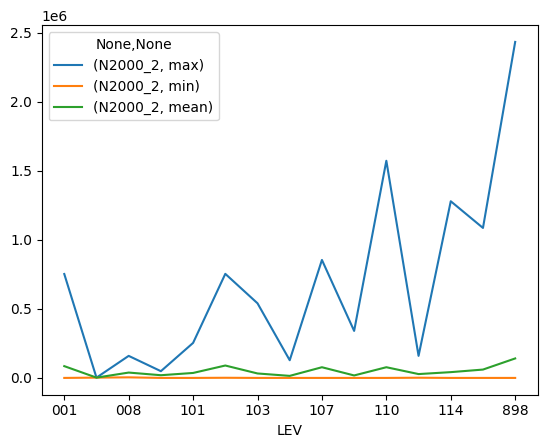

In [36]:
g2.plot()

In [41]:
g3=df.groupby([df['A07_2017'].str[0:2]])

In [44]:
g3.agg({'N2000_2':[max,min],'N2000_4':[np.mean,sum],'A01':np.count_nonzero})

N2000_2               N2000_4                    A01
              max    min           mean      sum count_nonzero
A07_2017                                                      
13         200423      0   38111.250000   609780            16
14        1573473      0  118652.909091  3915546            33
15         375759   2307   93070.166667   558421             6
17          92890      0   23030.142857   161211             7
18         361806      0   24617.034483   713894            29
19         754029   1569  176845.000000  1061070             6
20          17984   1543    9550.200000    47751             5
21          24816    338   12750.000000    89250             7
22         159690   1083   25102.555556   225923             9
23          97060   1553    9556.703704   258031            27
24          17765      0    5929.666667    35578             6
26         490975      0   59890.434783  4132440            69
27         730948   2390   98365.465116  4229715            43
29         549022      0   43634.982759  2530829            58
30         435023      0   49376.166667  1185028            24
31         248367  23552  200779.000000   401558             2
32         216354   1410  470503.500000   941007             2
33          93083      0   25891.795455  1139239            44
34        2434437      0   78593.333333  8959640           114
35         540653      0   31257.825000  2500626            80
36         340670    489   64415.062500  2061282            32
37          76968     80   33377.000000   333770            10
38         399415      0   50666.000000  3901282            77
39        1280006      0  104662.777778  9419650            90
40         208510      0   16906.172414   980558            58
41          28824   1094   13115.200000    65576             5
43          21847    227    8057.153846   104743            13
44         348143  29333  220975.750000   883903             4
45          16000  16000   17799.000000    17799             1
46          28064  28064   33047.000000    33047             1

----

## **16. Pandas的分层索引MultiIndex**  

### 为什么要学习分层索引：  
- #### 分层索引：在一个轴向上拥有多个索引层级(比如索引('NF','YF')的含义是：先按年份字段'NF'进行索引，然后在此基础上再按月份'YF'进行索引，所以是分层索引)，它可以用于表达更高维度数据
- #### 可以更方便地进行数据筛选，如果有序，则性能更好（意思是会自动使用二分查找法进行搜索，搜索量为O(LogN）级别
- #### groupby等操作的结果，如果是多key，结果的索引就是分层索引，因此需要会用
- #### 一般不需要自己创建分层索引（MultiIndex有构造行数，但一般不用）

### 本节提纲
1. Series的分层索引MultiIndex
2. Series的多层索引怎样筛选数据
3. DataFrame的分层索引MultiIndex
4. DataFrame的多层索引怎样筛选数据

In [50]:
import pandas as pd
import numpy as np
%matplotlib inline

In [12]:
df000651=pd.read_csv('./stocks/000651.csv',dtype={'SaleOrderID':'object','BuyOrderID':'object'})
df000651['Code']='000651'

df601012=pd.read_csv('./stocks/601012.csv',dtype={'SaleOrderID':'object','BuyOrderID':'object'})
df601012['Code']='601012'

df601288=pd.read_csv('./stocks/601288.csv',dtype={'SaleOrderID':'object','BuyOrderID':'object'})
df601288['Code']='601288'

df601318=pd.read_csv('./stocks/601318.csv',dtype={'SaleOrderID':'object','BuyOrderID':'object'})
df601318['Code']='601318'

df=pd.concat([df000651,df601012,df601288,df601318])

In [11]:
df['Code'].unique()

array(['000651', '601012', '601288', '601318'], dtype=object)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 534037 entries, 0 to 196766
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TranID           534037 non-null  int64  
 1   Time             534037 non-null  object 
 2   Price            534037 non-null  float64
 3   Volume           534037 non-null  int64  
 4   SaleOrderVolume  534037 non-null  int64  
 5   BuyOrderVolume   534037 non-null  int64  
 6   Type             534037 non-null  object 
 7   SaleOrderID      534037 non-null  object 
 8   SaleOrderPrice   534037 non-null  float64
 9   BuyOrderID       534037 non-null  object 
 10  BuyOrderPrice    534037 non-null  float64
 11  Code             534037 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 53.0+ MB


### **16.1 Series的分层索引MultiIndex**

In [33]:
df.groupby(['Code','Type'])['SaleOrderVolume']

In [14]:
ser=df.groupby(['Code','Type'])['SaleOrderVolume'].max()

In [15]:
ser

Code    Type
000651  B        521200
        S        521200
601012  B        300000
        S        292300
601288  B       1999800
        S       1000000
601318  B        450000
        S        500000
Name: SaleOrderVolume, dtype: int64

In [16]:
ser.index

MultiIndex([('000651', 'B'),
            ('000651', 'S'),
            ('601012', 'B'),
            ('601012', 'S'),
            ('601288', 'B'),
            ('601288', 'S'),
            ('601318', 'B'),
            ('601318', 'S')],
           names=['Code', 'Type'])

In [45]:
#第二级索引（这里是Type）变成了列，索引只剩下Code。实现了降低索引层级的目的
ser.unstack()

Type,B,S
Code,,
000651,521200,521200
601012,300000,292300
601288,1999800,1000000
601318,450000,500000


In [42]:
#重新回到二级索引
ser.reindex()

Code    Type
000651  B        521200
        S        521200
601012  B        300000
        S        292300
601288  B       1999800
        S       1000000
601318  B        450000
        S        500000
Name: SaleOrderVolume, dtype: int64

In [44]:
#一二级索引都变成了列。索引变为默认的整形值
ser.reset_index()

,Code,Type,SaleOrderVolume
0,000651,B,521200
1,000651,S,521200
2,601012,B,300000
3,601012,S,292300
4,601288,B,1999800
5,601288,S,1000000
6,601318,B,450000
7,601318,S,500000


### **16.2 Series有多层索引MultiIndex怎样进行数据筛选**

In [17]:
ser[('601012','S')]

292300

In [18]:
ser['601318']

Type
B    450000
S    500000
Name: SaleOrderVolume, dtype: int64

In [19]:
ser.loc['601318']

Type
B    450000
S    500000
Name: SaleOrderVolume, dtype: int64

In [21]:
#多级索引用元组tuple形式表达
ser.loc[('601012','S')]

292300

In [22]:
#多级索引也可以切片
ser.loc[:,'B']

Code
000651     521200
601012     300000
601288    1999800
601318     450000
Name: SaleOrderVolume, dtype: int64

In [23]:
ser.loc['601012',:]

Type
B    300000
S    292300
Name: SaleOrderVolume, dtype: int64

### **16.3 DataFrame的多层索引MultiIndex**

In [27]:
df.head()

,TranID,Time,Price,Volume,SaleOrderVolume,BuyOrderVolume,Type,SaleOrderID,SaleOrderPrice,BuyOrderID,BuyOrderPrice,Code
0,1,09:25:00,59.1,400,400,1400,S,1,53.87,1,65.84,000651
1,2,09:25:00,59.1,300,300,1400,S,2,53.87,1,65.84,000651
2,3,09:25:00,59.1,200,200,1400,S,3,53.87,1,65.84,000651
3,4,09:25:00,59.1,200,200,1400,S,4,53.87,1,65.84,000651
4,5,09:25:00,59.1,300,5900,1400,S,5,53.87,1,65.84,000651


In [39]:
df_setindex=df.set_index(['Code','Type'],drop=True)

In [40]:
df_setindex.head()

TranID      Time  Price  Volume  SaleOrderVolume  BuyOrderVolume  \
Code   Type                                                                     
000651 S          1  09:25:00   59.1     400              400            1400   
       S          2  09:25:00   59.1     300              300            1400   
       S          3  09:25:00   59.1     200              200            1400   
       S          4  09:25:00   59.1     200              200            1400   
       S          5  09:25:00   59.1     300             5900            1400   

            SaleOrderID  SaleOrderPrice BuyOrderID  BuyOrderPrice  
Code   Type                                                        
000651 S              1           53.87          1          65.84  
       S              2           53.87          1          65.84  
       S              3           53.87          1          65.84  
       S              4           53.87          1          65.84  
       S              5           53.87          1          65.84

In [43]:
df_group=df_setindex.groupby(['Code','Type'])

In [58]:
df_group.agg({'Volume':sum,'Price':[max,min,np.mean],'SaleOrderVolume':[max,min,np.mean],'BuyOrderVolume':[max,min,np.mean]})

Volume   Price                    SaleOrderVolume      \
                   sum     max    min        mean             max min   
Code   Type                                                             
000651 B      32927706   60.89  58.89   59.882903          521200  40   
       S      26204112   60.88  58.88   59.775608          521200   1   
601012 B      39652361  106.49  99.10  103.291065          300000   3   
       S      36746664  106.47  99.00  103.128819          292300   1   
601288 B     187950486    3.28   3.25    3.269567         1999800  55   
       S     192945337    3.27   3.24    3.261517         1000000  10   
601318 B      52390710   87.13  85.18   86.137305          450000   1   
       S      65655803   87.12  85.18   85.971901          500000   9   

                           BuyOrderVolume                      
                      mean            max  min           mean  
Code   Type                                                    
000651 B      10115.856865         502800  100    9298.015934  
       S      12325.993589         502800  100    5076.457430  
601012 B       3529.630934         250000    4    7462.213763  
       S       6031.226239         226420    2    2585.271740  
601288 B     227582.965702        1000000  100  155431.002317  
       S     150060.602507        1000000  100  317755.910772  
601318 B       8323.024895         477200  100    8246.233522  
       S      28486.316602         477200    4    4329.469648

### **16.4 DataFrame有多层索引MultiIndex,怎么筛选数据**

**[重要知识]** 在选择数据时:

- 元组(key1,key2)代表筛选多层索引,key1表示第一级,key2表示第二级
- 列表[key1,key2]代表同一层的多个key,其中key1,key2是并列的同级索引

In [65]:
df.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            196757, 196758, 196759, 196760, 196761, 196762, 196763, 196764,
            196765, 196766],
           dtype='int64', length=534037)

In [67]:
df.loc[100]

,TranID,Time,Price,Volume,SaleOrderVolume,BuyOrderVolume,Type,SaleOrderID,SaleOrderPrice,BuyOrderID,BuyOrderPrice,Code
100,101,09:25:00,59.10,600,600,20300,S,101,53.87,72,62.84,000651
100,101,09:25:00,100.00,100,6200,100,B,125802,100.00,162441,100.00,601012
100,101,09:25:00,3.25,300,40000,300,S,197059,3.25,21365,3.25,601288
100,101,09:25:00,85.80,200,300,2100,B,119980,85.80,183483,85.80,601318


In [77]:
df_setindex.loc[('000651','S'),'Price']

/tmp/ipykernel_18428/152763653.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_setindex.loc[('000651','S'),'Price']


Code    Type
000651  S       59.1
        S       59.1
        S       59.1
        S       59.1
        S       59.1
                ... 
        S       59.0
        S       59.0
        S       59.0
        S       59.0
        S       59.0
Name: Price, Length: 50071, dtype: float64

#### **PerformanceWarning: indexing past lexsort depth may impact performance.问题的原因与解决**
#### 原因: 多重索引没有排序,会影响性能
#### 解决: 对索引排序

In [78]:
df_setindex.sort_index(inplace=True)

In [85]:
#警告错误没有了
df_setindex.loc[('000651','B')]

TranID      Time  Price  Volume  SaleOrderVolume  BuyOrderVolume  \
Code   Type                                                                     
000651 B         11  09:25:00   59.1     100             3400             100   
       B         12  09:25:00   59.1     100             3400             100   
       B         13  09:25:00   59.1     100             3400             100   
       B         14  09:25:00   59.1     100             3400             100   
       B         15  09:25:00   59.1     100             3400             100   
...             ...       ...    ...     ...              ...             ...   
       B     101890  15:00:00   59.0     100            17600             100   
       B     101891  15:00:00   59.0     200            17600             200   
       B     101892  15:00:00   59.0     100            17600             100   
       B     101893  15:00:00   59.0    2400            17600            2400   
       B     101894  15:00:00   59.0     100            17600             100   

            SaleOrderID  SaleOrderPrice BuyOrderID  BuyOrderPrice  
Code   Type                                                        
000651 B              8           53.87         11          65.84  
       B              8           53.87         12          65.84  
       B              8           53.87         13          65.84  
       B              8           53.87         14          65.84  
       B              8           53.87         15          65.84  
...                 ...             ...        ...            ...  
       B         101871           57.97     101890          59.01  
       B         101871           57.97     101891          59.01  
       B         101871           57.97     101892          59.01  
       B         101871           57.97     101893          59.01  
       B         101871           57.97     101894          59.01  

[52468 rows x 10 columns]

In [96]:
#列表表示同层的多个key
df_setindex.loc[['000651','601012'],['Price','Volume']]

Price  Volume
Code   Type                
000651 B      59.10     100
       B      59.10     100
       B      59.10     100
       B      59.10     100
       B      59.10     100
...             ...     ...
601012 S     104.46     100
       S     104.46     100
       S     104.46      58
       S     104.46     100
       S     104.46     100

[305087 rows x 2 columns]

In [97]:
#元组与列表混合使用
df_setindex.loc[(['000651','601012'],'B'),['Price','Volume']]

Price  Volume
Code   Type                
000651 B      59.10     100
       B      59.10     100
       B      59.10     100
       B      59.10     100
       B      59.10     100
...             ...     ...
601012 B     104.46     100
       B     104.46    2500
       B     104.46     100
       B     104.46     100
       B     104.46     400

[155325 rows x 2 columns]

In [122]:
#slice(None)代表筛选这一索引的所有内容
df_setindex.loc[(slice(None),'B'),:]

TranID      Time  Price  Volume  SaleOrderVolume  BuyOrderVolume  \
Code   Type                                                                     
000651 B         11  09:25:00  59.10     100             3400             100   
       B         12  09:25:00  59.10     100             3400             100   
       B         13  09:25:00  59.10     100             3400             100   
       B         14  09:25:00  59.10     100             3400             100   
       B         15  09:25:00  59.10     100             3400             100   
...             ...       ...    ...     ...              ...             ...   
601318 B     196681  15:00:00  85.18     200           184958             200   
       B     196682  15:00:00  85.18     300           184958             300   
       B     196683  15:00:00  85.18     500           184958             500   
       B     196766  15:00:00  85.18    1000           262500            1000   
       B     196766  15:00:00  85.18    1000           262500            1000   

            SaleOrderID  SaleOrderPrice BuyOrderID  BuyOrderPrice  
Code   Type                                                        
000651 B              8           53.87         11          65.84  
       B              8           53.87         12          65.84  
       B              8           53.87         13          65.84  
       B              8           53.87         14          65.84  
       B              8           53.87         15          65.84  
...                 ...             ...        ...            ...  
601318 B        8493946           85.18    8494895          85.18  
       B        8493946           85.18    8496712          85.18  
       B        8493946           85.18    8497902          85.18  
       B        8493946           85.18    8498955          85.18  
       B        8493946           85.18    8498955          85.18  

[262392 rows x 10 columns]

In [123]:
df_setindex.reset_index()

,Code,Type,TranID,Time,Price,Volume,SaleOrderVolume,BuyOrderVolume,SaleOrderID,SaleOrderPrice,BuyOrderID,BuyOrderPrice
0,000651,B,11,09:25:00,59.10,100,3400,100,8,53.87,11,65.84
1,000651,B,12,09:25:00,59.10,100,3400,100,8,53.87,12,65.84
2,000651,B,13,09:25:00,59.10,100,3400,100,8,53.87,13,65.84
3,000651,B,14,09:25:00,59.10,100,3400,100,8,53.87,14,65.84
4,000651,B,15,09:25:00,59.10,100,3400,100,8,53.87,15,65.84
...,...,...,...,...,...,...,...,...,...,...,...,...
534032,601318,S,196761,15:00:00,85.18,500,243258,500,8493946,85.18,8454911,85.18
534033,601318,S,196762,15:00:00,85.18,500,243258,500,8493946,85.18,8457781,85.18
534034,601318,S,196763,15:00:00,85.18,100,243258,100,8493946,85.18,8461234,85.18
534035,601318,S,196764,15:00:00,85.18,100,243258,100,8493946,85.18,8474391,85.18
